### 1. Load the train and test datasets

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parent_directory = os.path.abspath(os.path.join('..'))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, '..'))

sys.path.append(parent_directory)
sys.path.append(grandparent_directory)

# print("Current sys.path:", sys.path)  # To confirm that the path is correctly added
# print("Parent directory:", os.path.abspath(os.path.join('...')))  # To verify the direct

from data_processing_utils.data_processing_functions import load_list_from_txt
train_feather_path = "../../data/train_test_splits/cog_train_family_tax_level.feather"
test_feather_path = "../../data/train_test_splits/cog_test_family_tax_level.feather"
global_vocab_path = "../../data/train_test_splits/global_vocab.txt"

train_df = pd.read_feather(train_feather_path)
val_df = pd.read_feather(test_feather_path)
global_vocab = load_list_from_txt(global_vocab_path)

train_values = train_df.iloc[:, 1:-13].values

sample_names = train_df.iloc[:, 0].values
cog_names = train_df.iloc[:, 1:-13].columns.tolist()
print(f"Number of samples = {len(sample_names)}")
print(f"Number of COGs = {len(cog_names)}")
print(f"Vocabulary size = {len(global_vocab)}")

Number of samples = 90445
Number of COGs = 12873
Vocabulary size = 12873


12873


Text(0.5, 1.0, 'COG presence distribution (log-scale)')

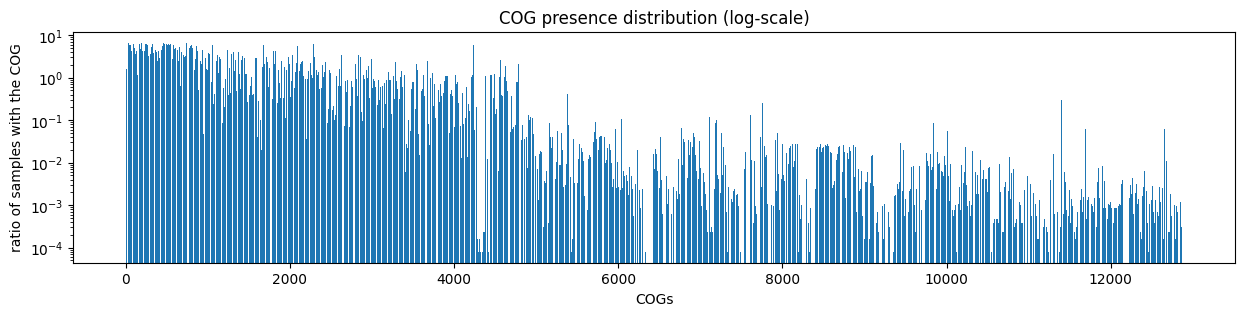

In [2]:
df = pd.DataFrame(train_values)
df_binary = df.gt(0).astype(int)
column_sums = df_binary.sum().values
print(len(column_sums))

plt.figure(figsize=(15, 3))
plt.bar(range(len(column_sums)), [c/len(cog_names) for c in column_sums], color='tab:blue')
plt.xlabel("COGs")
plt.ylabel("ratio of samples with the COG")
plt.yscale("log")
plt.title("COG presence distribution (log-scale)")

### 2. Sample space

#### 2.1 tSNE space of the samples in the origial train dataset

In [ ]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
train_samples = tsne_bin.fit_transform(train_values)

In [30]:
taxa_level = "class"  #'domain', 'phylum', 'class', 'order', 'family', 'group', 'species'
taxa_labels = train_df[taxa_level]
print(f"Found {len(np.unique(taxa_labels))} unique groups at {taxa_level} level for {len(taxa_labels)} samples")

Found 546 unique groups at class level for 90445 samples


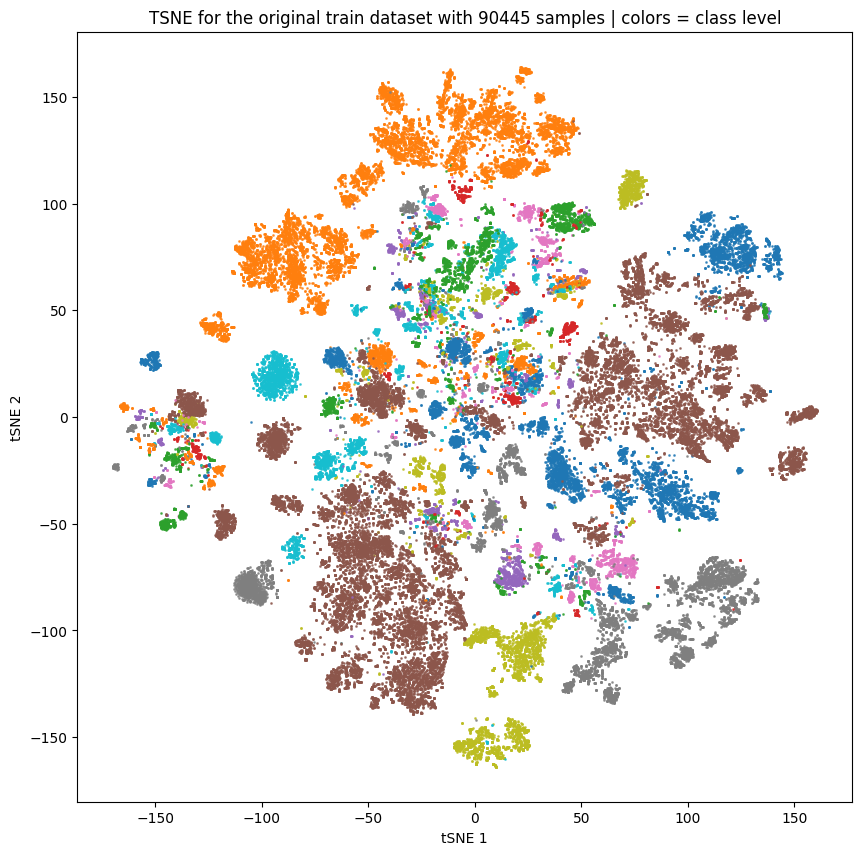

In [55]:
import seaborn as sns
unique_labels = np.unique(taxa_labels)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  # Get distinct colors
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = taxa_labels == label  # Filter points for the specific label
    plt.scatter(train_samples[:, 0][mask], train_samples[:, 1][mask], color=color_map[label], label=label, s=1, alpha=0.7)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the original train dataset with {len(sample_names)} samples | colors = {taxa_level} level")
plt.show()

### 3. Feature space

#### 3.1. Download a table of COG annotations

In [8]:
from post_train_process_utils import create_cogs_with_functions_df

functional_df = create_cogs_with_functions_df()

Downloaded cog-20.def.tab successfully.
First few rows of functional_df with Meta_Category:


#### 3.2. Pre-training feature set

In [9]:
# Merge the train COGs with their annotations
df_cogs = pd.DataFrame(train_values.T)

# Add the list of strings as the first column
df_cogs.insert(0, 'COG_ID', cog_names)
df_cogs = df_cogs.merge(functional_df[["COG_ID", "Category", "Meta_Category"]], on="COG_ID", how="left") 

# Replace Nan values by "no_label"
df_cogs['Meta_Category'] = df_cogs['Meta_Category'].fillna('no_label')
df_cogs = df_cogs.dropna(subset=["Meta_Category"])
df_cogs_val = df_cogs.iloc[:, 1:-2].values
print(f"df_cogs_val shape = {df_cogs_val.shape}")

df_cogs_val shape = (12873, 90445)


In [ ]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=10, learning_rate=5, max_iter=2000)
pretrain_features_tsne = tsne_bin.fit_transform(df_cogs_val)

#### 3.3. Post-training feature embedding weights

In [10]:
from post_train_process_utils import load_model

# Load a trained model
st_path = 'full_set_transf_embedd_124_heads_4_sab_2_BCE.pth'
set_transformer = load_model(st_path, global_vocab, DEVICE)

# Extract only the COG identity embeddings (ignoring any additional count processing)
vocab_size = set_transformer.vocab_size 
cog_identity_embeddings = set_transformer.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
print("COG identity embeddings shape:", cog_identity_embeddings.shape)

df_cog_embedd = pd.DataFrame(cog_identity_embeddings)
df_cog_embedd["COG_Index"] = np.arange(vocab_size)
df_cog_embedd = df_cog_embedd.merge(functional_df[["COG_Index", "Category", "Meta_Category"]], on="COG_Index", how="left")
df_cog_embedd['Meta_Category'] = df_cog_embedd['Meta_Category'].fillna('no_label')
df_cog_embedd = df_cog_embedd.dropna(subset=["Meta_Category"])

df_cog_embedd_val = df_cog_embedd.iloc[:, :-3].values
print("COG identity embeddings shape (values):", df_cog_embedd_val.shape)

COG identity embeddings shape: (12873, 124)
COG identity embeddings shape (values): (12873, 124)


In [7]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
embedd_weights_tsne = tsne_bin.fit_transform(df_cog_embedd_val)
embedd_weights_tsne.shape

NameError: name 'df_cog_embedd_val' is not defined

#### 3.4. Randomly generated initial feature weights

In [43]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

vocab_size = len(global_vocab)  
embedding_dim = df_cog_embedd_val.shape[1]  
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab_size-1)

# Apply Xavier initialization to the weights (same as in the model)
nn.init.xavier_uniform_(embedding_layer.weight)

# Extract the randomly initialized embedding weights
pre_training_rand_embeddings = embedding_layer.weight.data.clone()
pre_training_rand_embeddings_np = pre_training_rand_embeddings.numpy()
pre_training_rand_embeddings.shape

torch.Size([12873, 124])

In [44]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
pre_train_rand_tsne = tsne_bin.fit_transform(pre_training_rand_embeddings_np)
pre_train_rand_tsne.shape

(12873, 2)

#### 3.5. Hot-encoded features

In [45]:
one_hot_encoding = np.eye(vocab_size)  # One-hot for each COG_ID
one_hot_encoding.shape

(12873, 12873)

In [46]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
one_hot_encod_tsne = tsne_bin.fit_transform(one_hot_encoding)
one_hot_encod_tsne.shape

(12873, 2)

#### 3.6. Visualization of the feature tSNE projections

In [47]:
import seaborn as sns
# Color map for the COG categories
category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}


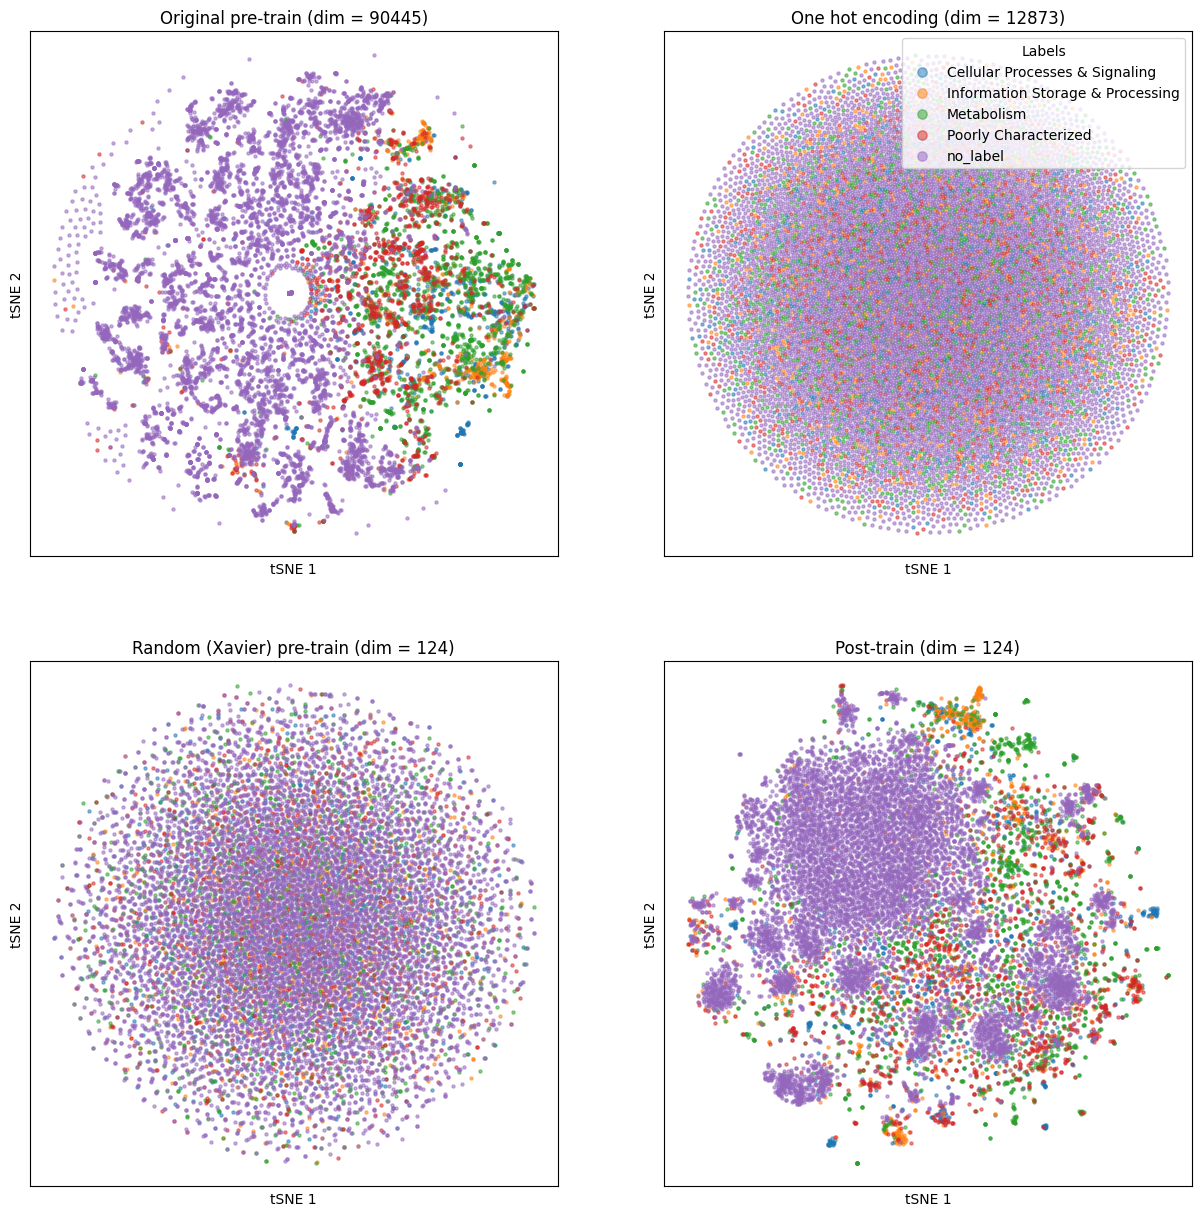

In [60]:
plt.figure(figsize=(15, 15))

# 1: Original pre-training tSNE feature projection
plt.subplot(2, 2, 1)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(pretrain_features_tsne[:, 0][mask], pretrain_features_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"Original pre-train (dim = {df_cogs_val.shape[1]})")
plt.xticks([])
plt.yticks([])

# 2: One hot-encoded feature space
plt.subplot(2, 2, 2)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(one_hot_encod_tsne[:, 0][mask], one_hot_encod_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"One hot encoding (dim = {one_hot_encoding.shape[1]})")
plt.xticks([])
plt.yticks([])

# 3: Randomly generated with Xavier initialization features
plt.subplot(2, 2, 3)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(pre_train_rand_tsne[:, 0][mask], pre_train_rand_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"Random (Xavier) pre-train (dim = {pre_training_rand_embeddings.shape[1]})")
plt.xticks([])
plt.yticks([])

# 4: Post-training feature embeddings
plt.subplot(2, 2, 4)

for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(embedd_weights_tsne[:, 0][mask], embedd_weights_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.5)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"Post-train (dim = {df_cog_embedd_val.shape[1]})")
plt.grid("True")
plt.xticks([])
plt.yticks([])

#plt.suptitle("COG Embeddings Comparison", fontsize=16)

plt.show()

### 4. Visualize the trained model intermediate projections

In [11]:
# Generate the data loader for the train dataset to do the feed forward
from post_train_process_utils import generate_noisy_dataset

batch_size = 10
pad_idx = len(global_vocab) # padding size
train_loader = generate_noisy_dataset(train_df, global_vocab, batch_size, pad_idx, fn_rate=0, fp_rate=0)

In [12]:
st_path = 'full_set_transf_embedd_124_heads_4_sab_2_BCE.pth'
set_transformer = load_model(st_path, global_vocab, DEVICE)
set_transformer.to(DEVICE)

GenomeSetTransformer(
  (cog_embedding): Embedding(12874, 124, padding_idx=12873)
  (count_linear): Linear(in_features=1, out_features=124, bias=True)
  (sab_blocks): ModuleList(
    (0-1): 2 x SAB(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=124, out_features=124, bias=True)
      )
      (ln1): LayerNorm((124,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=124, out_features=124, bias=True)
        (1): ReLU()
        (2): Linear(in_features=124, out_features=124, bias=True)
      )
      (ln2): LayerNorm((124,), eps=1e-05, elementwise_affine=True)
    )
  )
  (pma): PMA(
    (mha): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=124, out_features=124, bias=True)
    )
    (ln): LayerNorm((124,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=248, out_features=124, bias=True)
    (1): ReLU()
    (2): Linear(

#### 4.1 Visualize the attention scores

In [41]:
from tqdm import tqdm

# Functions for creating the hooks
def capture_attention_weights(module, input, output):
    global attention_weights
    attention_weights = output[1].to(DEVICE)  # The second element is the attention weights

def register_last_sab_attent_scores_hooks(model):
    last_sab_block = model.sab_blocks[-1]
    last_sab_block.mha.register_forward_hook(capture_attention_weights)

# Create last sab mha hook
register_last_sab_attent_scores_hooks(set_transformer)

# Initialize the matrix of attention scores
attention_scores_mtr = torch.zeros(pad_idx, pad_idx, device=DEVICE)# np.zeros((pad_idx, pad_idx), dtype=object) # [[(0,0) for _ in range(pad_idx)] for _ in range(pad_idx)]
attention_counts_mtr = torch.zeros(pad_idx, pad_idx, device=DEVICE)  # Matrix to track how often each pair is attended

set_transformer.eval()
set_transformer.to(DEVICE)
with torch.no_grad():
    for tokens, mask, targets in tqdm(train_loader, desc="Processing Batches"):
       # count += 1
        tokens = tokens.to(DEVICE)
        mask = mask.to(DEVICE)
        
        preds = set_transformer(tokens, mask)

        batch_size = tokens.shape[0]
        seq_len = tokens.shape[1]

        # Convert tokens to indices (COG IDs)
        cog_ids = tokens[:, :, 0].long()  # (batch_size, seq_len)
        token_counts = tokens[:, :, 1]    # (batch_size, seq_len)

        for sample_id in range(len(cog_ids)):
            present_tokens_mask = token_counts[sample_id] > 0
            present_cogs_ids = cog_ids[sample_id][present_tokens_mask]

            for i, row_cog_id in enumerate(present_cogs_ids):
               # print(f"i = {i}; row_cog_id = {row_cog_id}")
                values = attention_weights[sample_id][i][present_tokens_mask]
                attention_scores_mtr[row_cog_id, present_cogs_ids]  += values
                attention_counts_mtr[row_cog_id, present_cogs_ids] += 1



Processing Batches:  33%|████████████████████████████████▎                                                                | 3018/9045 [1:56:49<3:53:18,  2.32s/it]


KeyboardInterrupt: 

In [42]:
average_attention_scores_mtr = attention_scores_mtr / (attention_counts_mtr + 1e-9)
average_attention_scores_mtr_log = torch.log(torch.clamp(average_attention_scores_mtr, min=1e-5))
average_attention_scores_mtr_log.shape
average_attention_scores_mtr_log

tensor([[ -8.0501,  -7.2318,  -8.2473,  ...,  -6.4942,  -8.2291,  -9.6194],
        [ -8.6448,  -6.4685,  -7.2215,  ...,  -7.7563,  -7.3638,  -7.9661],
        [ -8.3333,  -8.2946,  -6.4472,  ...,  -5.5998,  -8.5520, -11.5129],
        ...,
        [ -7.7992,  -5.4988,  -5.6124,  ...,  -6.6124, -11.5129, -11.5129],
        [-11.5129,  -8.3701, -11.5129,  ..., -11.5129,  -7.7571, -11.5129],
        [ -8.5166,  -9.6793, -11.5129,  ..., -11.5129, -11.5129,  -7.9178]],
       device='cuda:0')

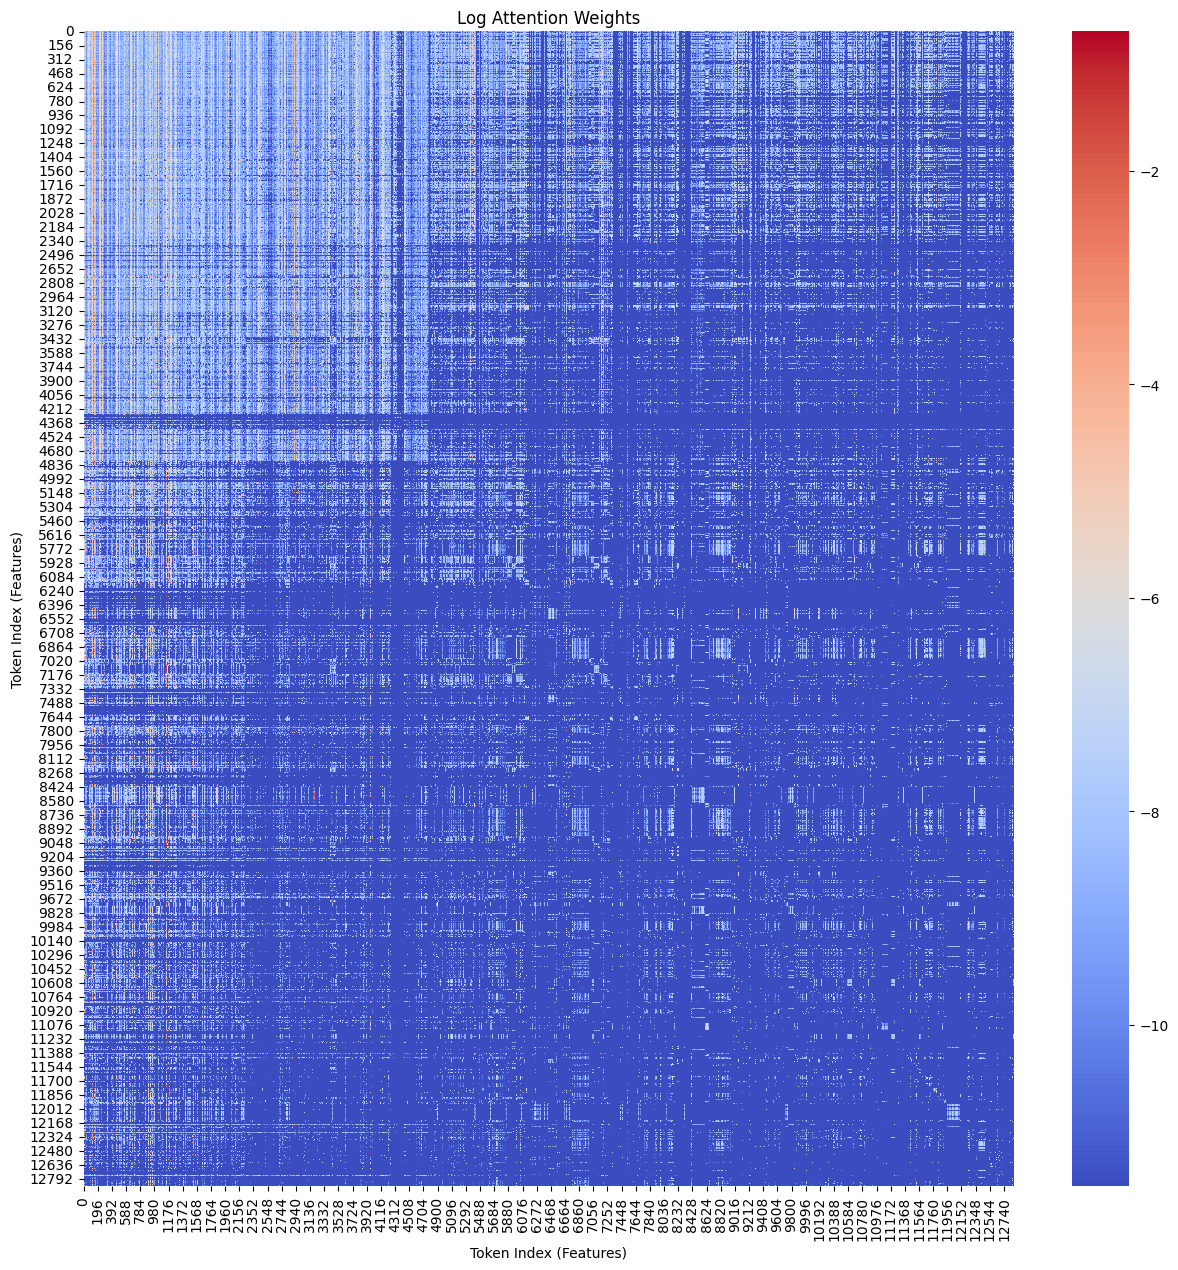

In [43]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(average_attention_scores_mtr_log.cpu().numpy(), cmap='coolwarm', cbar=True)
plt.title(f"Log Attention Weights")
plt.xlabel("Token Index (Features)")
plt.ylabel("Token Index (Features)")
plt.show()

In [13]:
# Sorting COG indices wrt the function

global_vocab_pd = pd.DataFrame(global_vocab, columns=["COG_ID"])
merged_df = pd.merge(global_vocab_pd, functional_df, on='COG_ID', how='left')

# Fill missing values in 'value2' with 'no_label'
merged_df['Meta_Category'] = merged_df['Meta_Category'].fillna('no_label')
merged_df['COG_Index'] = merged_df.index

uniq_categ = np.unique(merged_df['Meta_Category'])
print(uniq_categ)

# Sort the DataFrame by the 'Group' column first, and then by 'COG_Index'
merged_df = merged_df.sort_values(by=['Meta_Category', 'COG_Index'], ascending=[True, True])
sorting_ind = merged_df['COG_Index']
merged_df


['Cellular Processes & Signaling' 'Information Storage & Processing'
 'Metabolism' 'Poorly Characterized' 'no_label']


COG_ID Category                   Meta_Category  COG_Index
66        COG0068        O  Cellular Processes & Signaling         66
69        COG0071        O  Cellular Processes & Signaling         69
82        COG0084        N  Cellular Processes & Signaling         82
168       COG0170       OM  Cellular Processes & Signaling        168
199       COG0201        U  Cellular Processes & Signaling        199
...           ...      ...                             ...        ...
12868  arCOG15264      NaN                        no_label      12868
12869  arCOG15268      NaN                        no_label      12869
12870  arCOG15271      NaN                        no_label      12870
12871  arCOG15273      NaN                        no_label      12871
12872  arCOG15274      NaN                        no_label      12872

[12873 rows x 4 columns]

In [14]:
grouped_indices = merged_df.groupby('Meta_Category').apply(lambda group: group.index.tolist())
category_lengths = grouped_indices.apply(len)
category_lengths

/scratch/ipykernel_3238111/4141767906.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_indices = merged_df.groupby('Meta_Category').apply(lambda group: group.index.tolist())


Meta_Category
Cellular Processes & Signaling       938
Information Storage & Processing     712
Metabolism                          1568
Poorly Characterized                1252
no_label                            8403
dtype: int64

In [46]:
shuffled_attn_matrix_log = torch.log(torch.clamp(average_attention_scores_mtr[sorting_ind, :][:, sorting_ind], min=1e-5))

#shuffled_attn_matrix = attention_scores_mtr[sorting_ind, :][:, sorting_ind]
shuffled_attn_matrix_log

tensor([[ -6.5163,  -7.4740,  -7.5064,  ...,  -9.3289,  -7.6857,  -7.7067],
        [ -8.9021,  -4.8874,  -6.9151,  ..., -11.5129,  -8.3301, -11.5129],
        [ -8.1502,  -6.0745,  -5.6643,  ...,  -9.7110, -11.5129, -11.5129],
        ...,
        [ -6.9534,  -8.5750,  -8.1700,  ...,  -6.6124, -11.5129, -11.5129],
        [ -7.5335, -10.2249, -11.5129,  ..., -11.5129,  -7.7571, -11.5129],
        [ -8.3303,  -7.5320, -11.5129,  ..., -11.5129, -11.5129,  -7.9178]],
       device='cuda:0')

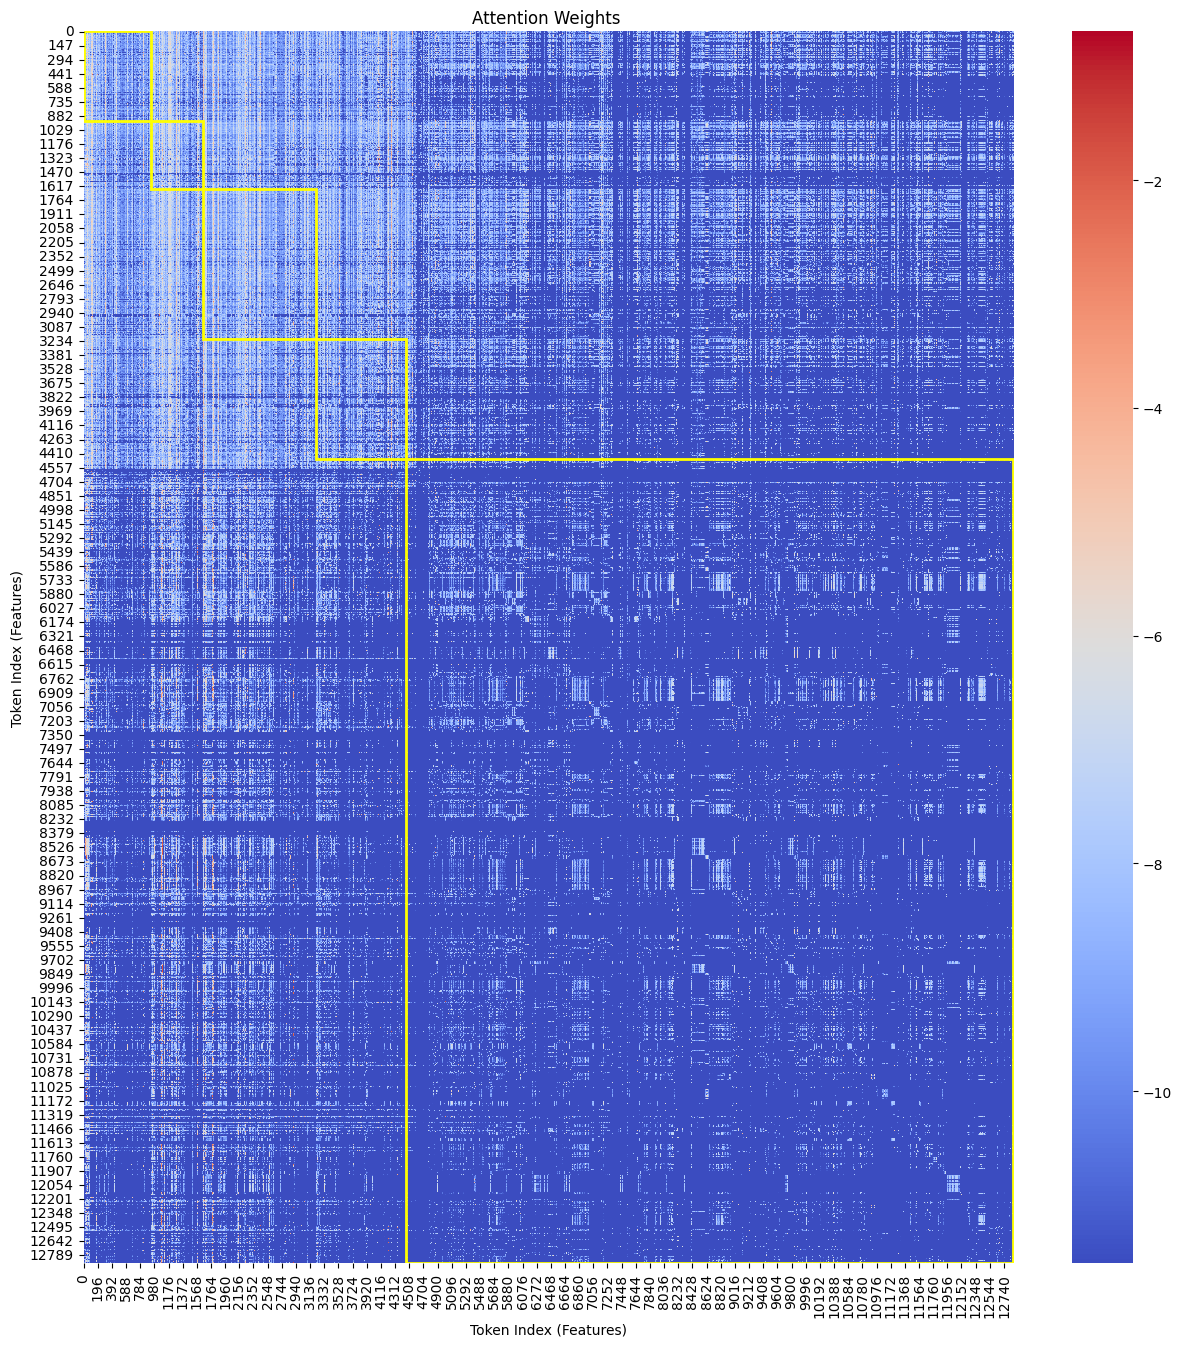

In [47]:
import seaborn as sns
from matplotlib.patches import Rectangle

category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}

blocks = [
    (0, 937, 0, 937),
    (937, 937+712, 937, 937+712),
    (937+712, 937+712+1568, 937+712, 937+712+1568),
    (937+712+1568, 937+712+1568+1252, 937+712+1568, 937+712+1568+1252),
    (937+712+1568+1252, 937+712+1568+1252+8403, 937+712+1568+1252, 937+712+1568+1252+8403)
]
category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(15, 16))
ax = sns.heatmap(shuffled_attn_matrix_log.cpu().numpy(), cmap='coolwarm', cbar=True) #[:4500, :4500]
counter = 0
for (x_start, x_end, y_start, y_end) in blocks:
    label = unique_labels[counter]
    rect = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                     linewidth=2, edgecolor="yellow", facecolor='none')
    counter += 1
    ax.add_patch(rect)

plt.title(f"Attention Weights ")
plt.xlabel("Token Index (Features)")
plt.ylabel("Token Index (Features)")
plt.show()

#### 4.2 Visualize the output of the PMA layer

In [6]:
import torch
from torch.utils.data import  DataLoader
from data_processing_utils.data_processing_functions import GenomeDataset, collate_genomes

def generate_noisy_dataset(df, global_vocab, batch_size, pad_idx, fn_rate, fp_rate, count_noise_std=0, random_state=42):
     dataset = GenomeDataset(df, global_vocab,
                               false_negative_rate=fn_rate, false_positive_rate=fp_rate,
                               count_noise_std=count_noise_std, random_state=random_state)
     dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_genomes(batch, pad_idx=pad_idx))   
     return dataset_loader

batch_size = 10
pad_idx = len(global_vocab) # padding size
train_loader = generate_noisy_dataset(train_df, global_vocab, batch_size, pad_idx, fn_rate=0, fp_rate=0)


pma_outputs = []

def hook_fn(module, input, output):
    global pma_outputs
    output = output.squeeze(0) 
    pma_outputs += list(output.detach().cpu().numpy())

def register_hooks(model):
    model.pma.ln.register_forward_hook(hook_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_transformer = load_model(st_path, global_vocab, DEVICE)
set_transformer.to(device)
register_hooks(set_transformer)

In [7]:
#~20m
set_transformer.eval()
count = 0
with torch.no_grad():
    for tokens, mask, targets in train_loader:
        count += 1
        tokens = tokens.to(device)
        mask = mask.to(device)
        preds = set_transformer(tokens, mask)

In [8]:
train_values.shape
#pma_outputs.shape
pma_outputs = np.array(pma_outputs)
pma_outputs.shape

(90445, 124)

In [9]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
pma_outputs_tsne = tsne_bin.fit_transform(pma_outputs)

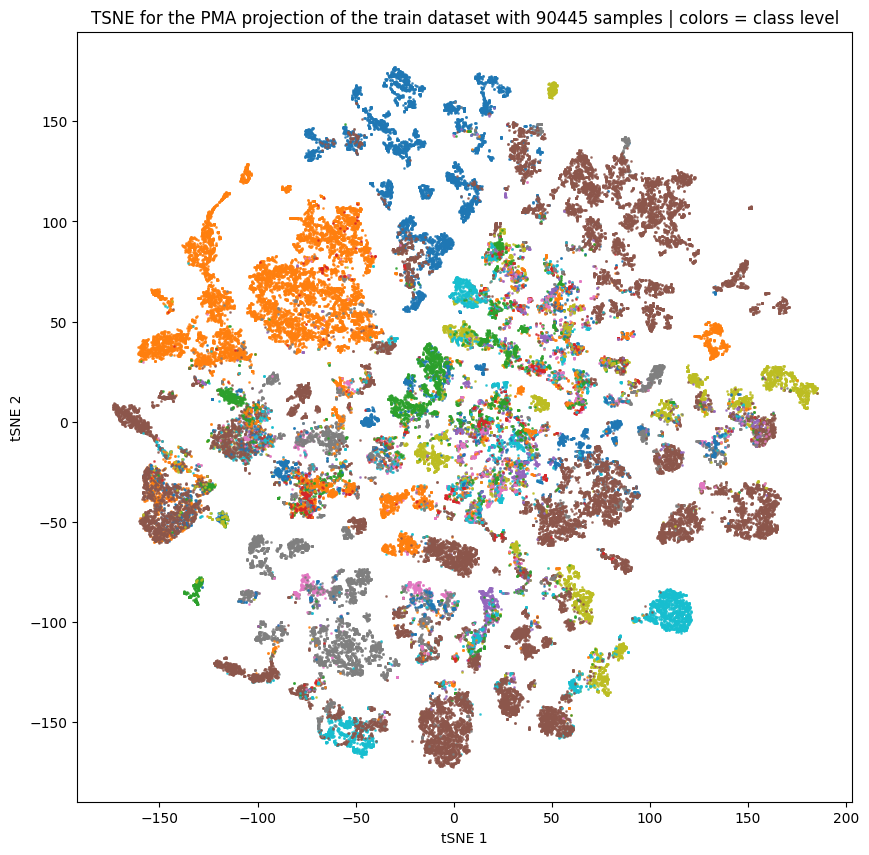

In [10]:
import seaborn as sns
taxa_level = "class"  #'domain', 'phylum', 'class', 'order', 'family', 'group', 'species'
taxa_labels = train_df[taxa_level]
unique_labels = np.unique(taxa_labels)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  # Get distinct colors
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = taxa_labels == label  # Filter points for the specific label
    plt.scatter(pma_outputs_tsne[:, 0][mask], pma_outputs_tsne[:, 1][mask], color=color_map[label], label=label, s=1, alpha=0.7)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the PMA projection of the train dataset with {len(sample_names)} samples | colors = {taxa_level} level")
plt.show()

### 5. Misclassified COGs

In [ ]:
from tqdm import tqdm
from collections import defaultdict

# Load the new model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_transformer = load_model(st_path, global_vocab, DEVICE)
set_transformer.to(device)

# Initialize dictionaries for misclassifications and correct classifications
misclassified_cogs_fp = {cog_name: 0 for cog_name in cog_names}  # False Positives
misclassified_cogs_fn = {cog_name: 0 for cog_name in cog_names}  # False Negatives
correct_cogs_tp = {cog_name: 0 for cog_name in cog_names}        # True Positives
correct_cogs_tn = {cog_name: 0 for cog_name in cog_names}        # True Negatives

set_transformer.eval()
num_samples_processed = 0
with torch.no_grad():
    for tokens, mask, targets in tqdm(train_loader, desc="Processing Batches"):
        tokens, mask, targets = tokens.to(device), mask.to(device), targets.to(device)
        preds = (set_transformer(tokens, mask) > 0.5).float()  
        num_samples_processed += len(tokens)

        # Identify misclassifications and correct classifications
        false_positives = (targets == 0) & (preds == 1)  
        false_negatives = (targets == 1) & (preds == 0)  
        true_positives = (targets == 1) & (preds == 1)  
        true_negatives = (targets == 0) & (preds == 0) 

        # Get indices of False Positives, False Negatives, True Positives, and True Negatives
        fp_indices = false_positives.nonzero(as_tuple=True)[1].cpu().numpy()
        fn_indices = false_negatives.nonzero(as_tuple=True)[1].cpu().numpy()
        tp_indices = true_positives.nonzero(as_tuple=True)[1].cpu().numpy()
        tn_indices = true_negatives.nonzero(as_tuple=True)[1].cpu().numpy()

        for idx in fp_indices:
            misclassified_cogs_fp[cog_names[idx]] += 1  

        for idx in fn_indices:
            misclassified_cogs_fn[cog_names[idx]] += 1  

        for idx in tp_indices:
            correct_cogs_tp[cog_names[idx]] += 1  

        for idx in tn_indices:
            correct_cogs_tn[cog_names[idx]] += 1  

Processing Batches:  61%|█████████████████████████████████████████████████████████████                                        | 5474/9045 [15:47<10:21,  5.75it/s]

In [32]:
def top_missclass(misclassified_cogs_fp, num_samples_processed, title):
    top_10_fp = sorted(misclassified_cogs_fp.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Extract COG names and counts separately
    top_10_fp_cogs, top_10_fp_counts = zip(*top_10_fp) if top_10_fp else ([], [])
    
    # Print results
    print(title)
    for cog, count in zip(top_10_fp_cogs, top_10_fp_counts):
        print(f"{cog}: misclassification rate {round(count/num_samples_processed,2)}")

top_missclass(misclassified_cogs_fp, num_samples_processed, "Top 10 FP Misclassified COGs:")
print()
top_missclass(misclassified_cogs_fn, num_samples_processed, "Top 10 FN Misclassified COGs:")

Top 10 FP Misclassified COGs:
COG0257: misclassification rate 0.27
COG0230: misclassification rate 0.25
COG0759: misclassification rate 0.24
COG0428: misclassification rate 0.22
COG1451: misclassification rate 0.2
COG0598: misclassification rate 0.19
COG1209: misclassification rate 0.19
COG0270: misclassification rate 0.19
COG1970: misclassification rate 0.19
COG1086: misclassification rate 0.19

Top 10 FN Misclassified COGs:
COG0393: misclassification rate 0.23
COG0827: misclassification rate 0.18
COG3654: misclassification rate 0.18
COG2314: misclassification rate 0.17
COG3210: misclassification rate 0.17
COG1106: misclassification rate 0.16
COG0338: misclassification rate 0.16
COG2253: misclassification rate 0.16
COG0863: misclassification rate 0.16
COG1881: misclassification rate 0.16


In [33]:
fp_cogs, fp_counts = zip(*misclassified_cogs_fp.items()) if misclassified_cogs_fp else ([], [])
fn_cogs, fn_counts = zip(*misclassified_cogs_fn.items()) if misclassified_cogs_fn else ([], [])
tp_cogs, tp_counts = zip(*correct_cogs_tp.items()) if correct_cogs_tp else ([], [])
tn_cogs, tn_counts = zip(*correct_cogs_tn.items()) if correct_cogs_tn else ([], [])

def accuracy(tp, tn, fp, fn):
    return (tp + tn)/(tp + tn + fp + fn)
    
def precision (tp, fp):
    return tp /(tp + fp)

def recall (tp, tn, fp, fn):
    return (tp + tn)/(tp + tn + fp + fn)    

def accuracy(tp, tn, fp, fn):
    return (tp + tn)/(tp + tn + fp + fn)

def plot_misclassification_histogram(cog_ids, counts, title, color):
    plt.figure(figsize=(15, 2))
    plt.bar(range(len(counts)), counts, color=color)
    plt.xlabel('COG ID')
    plt.ylabel('misclassification rate')
    plt.title(title)
    #plt.xticks(rotation=90, fontsize=8)
  #  plt.yscale("log")  # Log scale for better visualization
    plt.show()


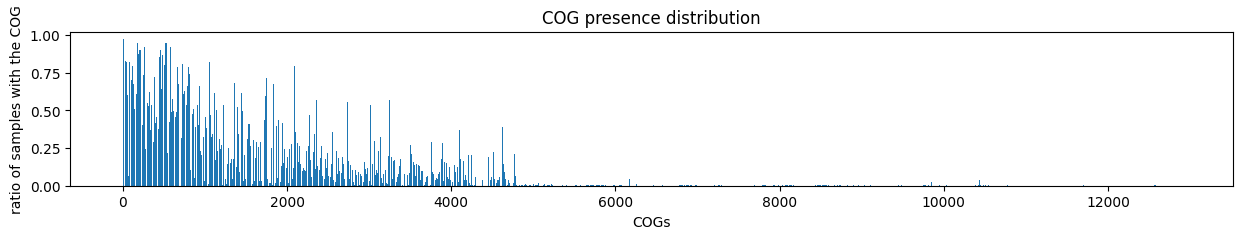

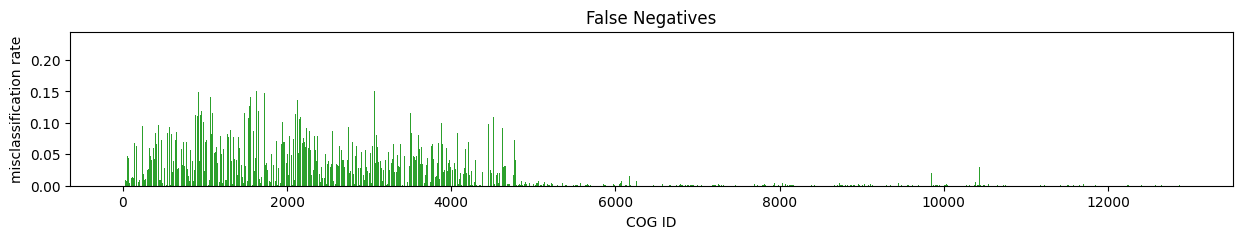

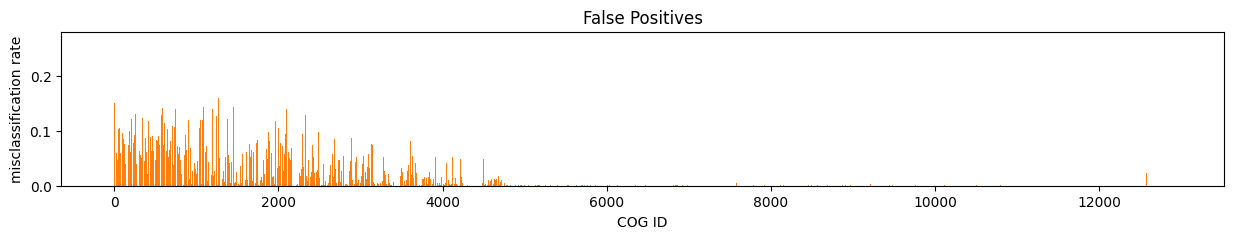

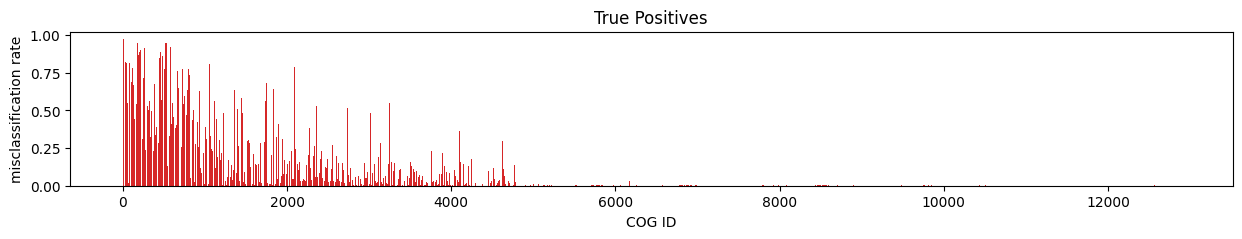

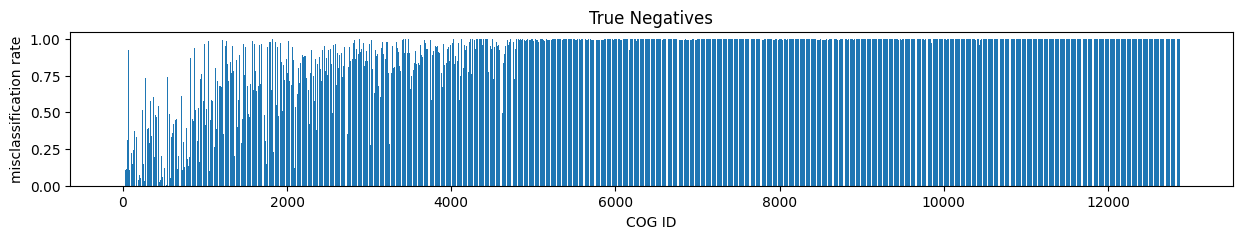

In [34]:

plt.figure(figsize=(15, 2))
plt.bar(range(len(column_sums)), [c/len(sample_names) for c in column_sums], color='tab:blue')
plt.xlabel("COGs")
plt.ylabel("ratio of samples with the COG")
#plt.yscale("log")
plt.title("COG presence distribution")    

plot_misclassification_histogram(fn_cogs, [f/num_samples_processed for f in fn_counts], 'False Negatives', 'tab:green')
plot_misclassification_histogram(fp_cogs, [f/num_samples_processed for f in fp_counts], 'False Positives', 'tab:orange')
plot_misclassification_histogram(tp_cogs, [f/num_samples_processed for f in tp_counts], 'True Positives', 'tab:red')
plot_misclassification_histogram(tn_cogs, [f/num_samples_processed for f in tn_counts], 'True Negatives', 'tab:blue')